### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

# Date processing

In [2]:
df = pd.read_csv("d.csv")
stops_df = pd.read_csv('stops.txt', delimiter=',', header=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


# getting rid of duplicates

In [3]:
df = df.drop_duplicates()
df

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642346,U809Z2P,Újezd,U2900Z1P,Střelecký ostrov,23:07:00,23:08:00,0,0,1,1,1,1,1,0,0
1642347,U2900Z1P,Střelecký ostrov,U483Z1P,Národní divadlo,23:08:00,23:09:00,0,0,1,1,1,1,1,0,0
1642376,U809Z2P,Újezd,U2900Z1P,Střelecký ostrov,16:21:00,16:22:00,0,0,1,1,1,1,1,0,0
1642414,U483Z2P,Národní divadlo,U2900Z2P,Střelecký ostrov,17:25:00,17:26:00,0,0,1,1,1,1,1,0,0


In [4]:
stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16435 entries, 0 to 16434
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   stop_id              16435 non-null  object 
 1   stop_name            15936 non-null  object 
 2   stop_lat             16435 non-null  float64
 3   stop_lon             16435 non-null  float64
 4   zone_id              15408 non-null  object 
 5   stop_url             0 non-null      float64
 6   location_type        16435 non-null  int64  
 7   parent_station       954 non-null    object 
 8   wheelchair_boarding  16435 non-null  int64  
 9   level_id             954 non-null    object 
 10  platform_code        14750 non-null  object 
 11  asw_node_id          15748 non-null  float64
 12  asw_stop_id          15354 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.6+ MB


### Normalizing Time and Preparing Data for Analysis

1. **Time Normalization**:
   - A custom function, `normalize_time`, is defined to normalize time strings (e.g., `26:30:00` to `02:30:00`) using modulo arithmetic on hours.
   - The function splits time into hours, minutes, and seconds, normalizes hours, and reassembles the time in `HH:MM:SS` format.

2. **Datetime Conversion**:
   - The normalized time strings in the `depart_from` and `arrive_to` columns are converted into proper datetime objects for further analysis.

In [5]:
def normalize_time(time_str):
    # Split the string to get hours, minutes, and seconds
    hours, minutes, seconds = map(int, time_str.split(':'))

    # Normalize hours using modulo 24
    normalized_hours = hours % 24
    return f"{normalized_hours:02}:{minutes:02}:{seconds:02}"

# Apply normalization to 'depart_from' and 'arrive_to'
df['depart_from'] = df['depart_from'].apply(normalize_time)
df['arrive_to'] = df['arrive_to'].apply(normalize_time)

# Specify the datetime format explicitly
df['depart_from'] = pd.to_datetime(df['depart_from'], format="%H:%M:%S")
df['arrive_to'] = pd.to_datetime(df['arrive_to'], format="%H:%M:%S")


## Preprocessing Tram Routes: Adding Positions for Each Node


## Steps in the Preprocessing

### 1. Aggregate Stops by Name
- Calculate the average latitude and longitude for each stop to ensure consistent positions for stops with duplicate names.

### 2. Map Stop Names to Positions
- Create a dictionary mapping stop names to their respective geographic positions (longitude, latitude).

### 3. Filter Tram Routes for a Specific Type
- Extract routes that match a specific `route_type` (e.g., `route_type == 0`).

In [6]:
# Aggregate stops by name and calculate average latitude and longitude
average_stops = stops_df.groupby('stop_name', as_index=False).agg({
    'stop_lat': 'mean',
    'stop_lon': 'mean'
})

# Create a dictionary to map stop names to their positions (longitude, latitude)
stop_coordinates = {
    row['stop_name']: (row['stop_lon'], row['stop_lat']) 
    for _, row in average_stops.iterrows()
}

# Filter tram routes for a specific type
tram_routes_filtered = df[df['route_type'] == 0].copy()

# Map positions for 'from' and 'to' stops
tram_routes_filtered['from_position'] = tram_routes_filtered['stop_from_name'].map(stop_coordinates)
tram_routes_filtered['to_position'] = tram_routes_filtered['stop_to_name'].map(stop_coordinates)

# Calculate travel time in seconds
tram_routes_filtered['travel_time_seconds'] = (tram_routes_filtered['arrive_to'] - tram_routes_filtered['depart_from']).dt.total_seconds()

# Keep only valid travel times
tram_routes = tram_routes_filtered[tram_routes_filtered['travel_time_seconds'] >= 0]
print(tram_routes.columns)

Index(['stop_from', 'stop_from_name', 'stop_to', 'stop_to_name', 'depart_from',
       'arrive_to', 'route_type', 'is_night', 'monday', 'tuesday', 'wednesday',
       'thursday', 'friday', 'saturday', 'sunday', 'from_position',
       'to_position', 'travel_time_seconds'],
      dtype='object')


### Visualizing Prague Tram Routes

This visualization represents the tram routes in Prague as a graph, where:
- **Nodes** represent tram stops.
- **Edges** represent connections between tram stops.

## Steps to Create the Graph

1. **Create the Graph:**
   - Add nodes for each tram stop with their geographic positions.
   - Add edges between tram stops representing connections.

2. **Position Nodes:**
   - Use pre-mapped geographic positions (`stop_lat` and `stop_lon`) for better spatial accuracy.

3. **Visualize the Graph:**
   - Nodes are colored in salmon.
   - Edges are gray to represent tram connections.
   - Node labels (stop names) are hidden for readability.

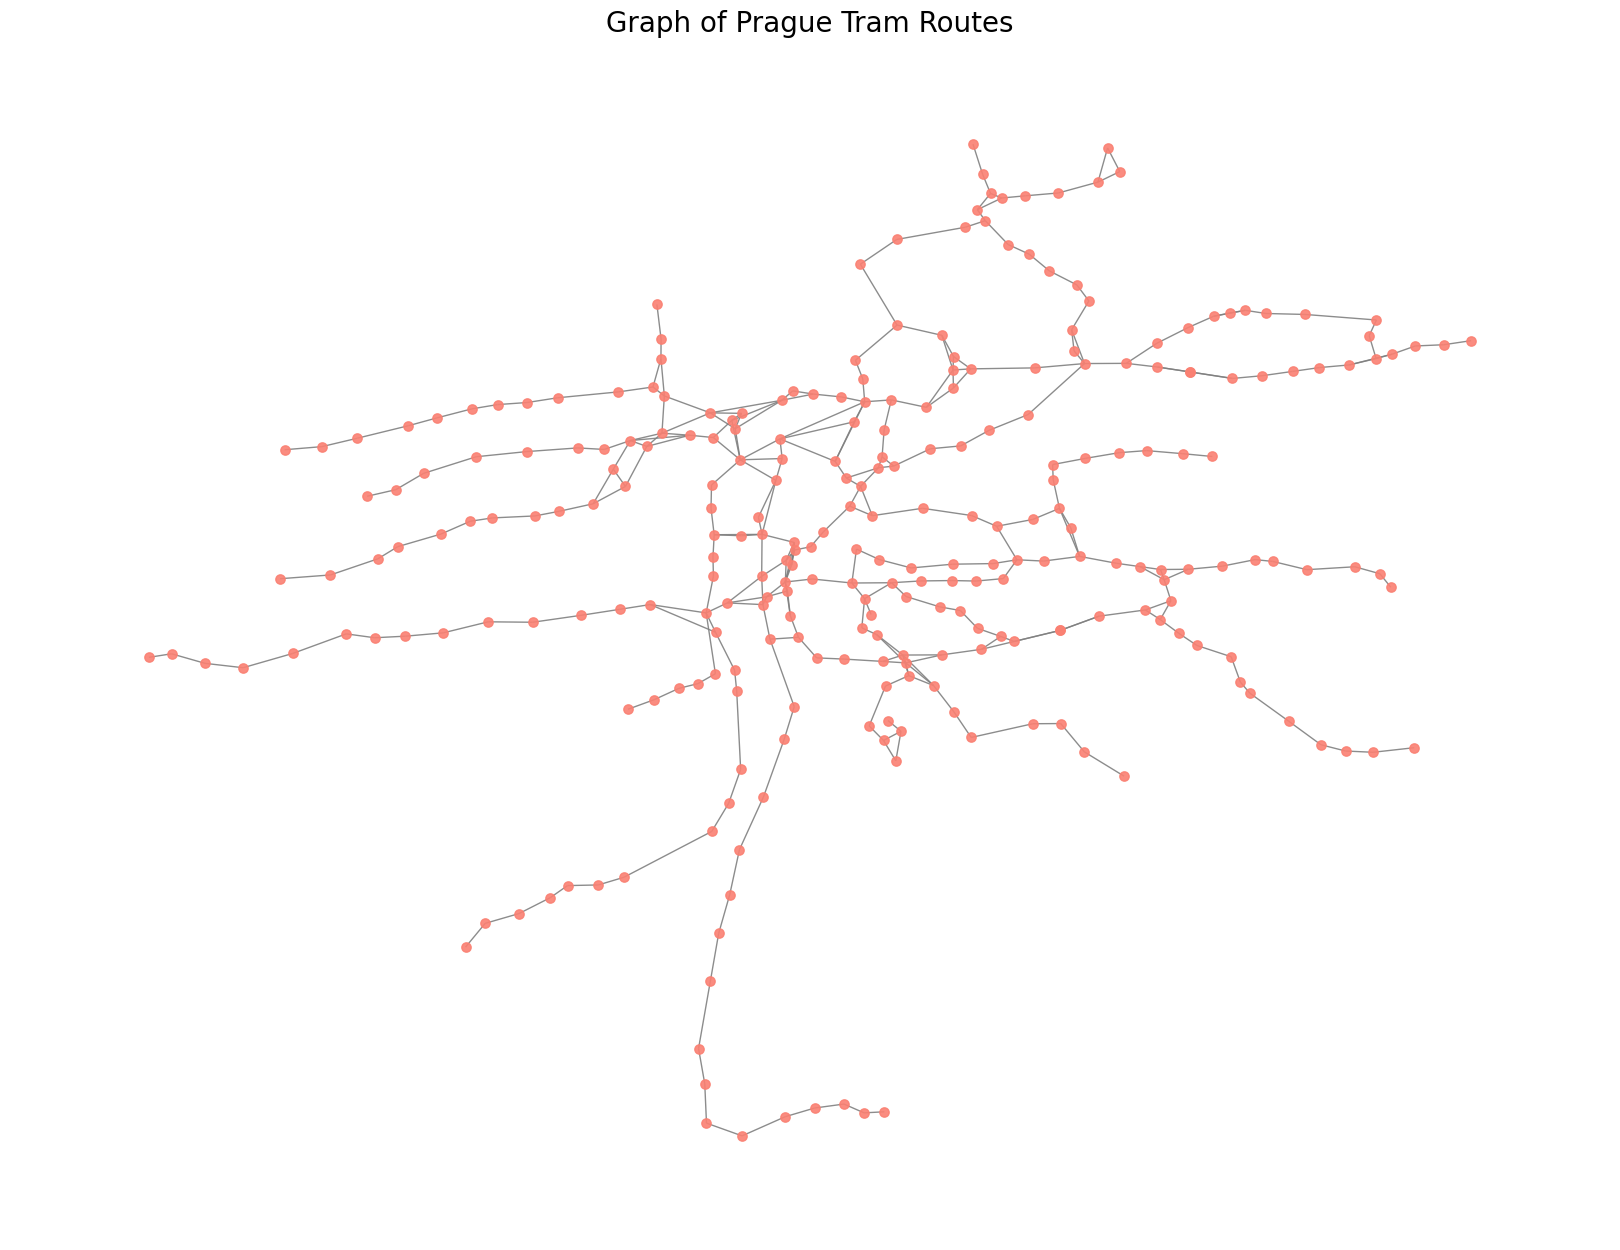

In [7]:
# Create a graph
G = nx.Graph()

# Add nodes and edges along with their positions and weights
for _, row in tram_routes.iterrows():
    G.add_node(row['stop_from_name'], pos=row['from_position'])
    G.add_node(row['stop_to_name'], pos=row['to_position'])
    G.add_edge(row['stop_from_name'], row['stop_to_name'])

# Extract positions for visualization
positions = nx.get_node_attributes(G, 'pos')
# Draw the graph with positions
plt.figure(figsize=(16, 12))

# Draw nodes and edges
nx.draw(
    G,
    pos=positions,  # Use mapped positions
    with_labels=False,
    node_size=45,
    font_color="black",
    node_color="salmon",
    edge_color="gray",
    alpha=0.9
)

# Add edge labels (travel times)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels={k: f"{int(v)} s" for k, v in edge_labels.items()},
    font_size=8
)

# Add a title
plt.title("Graph of Prague Tram Routes", fontsize=20)
plt.show()


# Degree Centrality Analysis

## Overview
This analysis calculates the **degree centrality** of nodes in a graph `G`. The results are visualized in a bar chart, and a sorted list of centrality values is displayed.

**Degree Centrality** measures the importance of a node based on the number of direct connections it has in the network.

### Visualization:
- The bar chart displays nodes sorted by their degree centrality.
- **Key observations:**
  - **Node "Malostranska"** has the highest degree centrality, indicating it is the most connected node in the graph.
  - Many nodes have similar and lower centrality, indicating less importance in terms of connectivity.

### Insights:
- **"Malostranska"** is likely a critical hub in the network due to its high centrality.

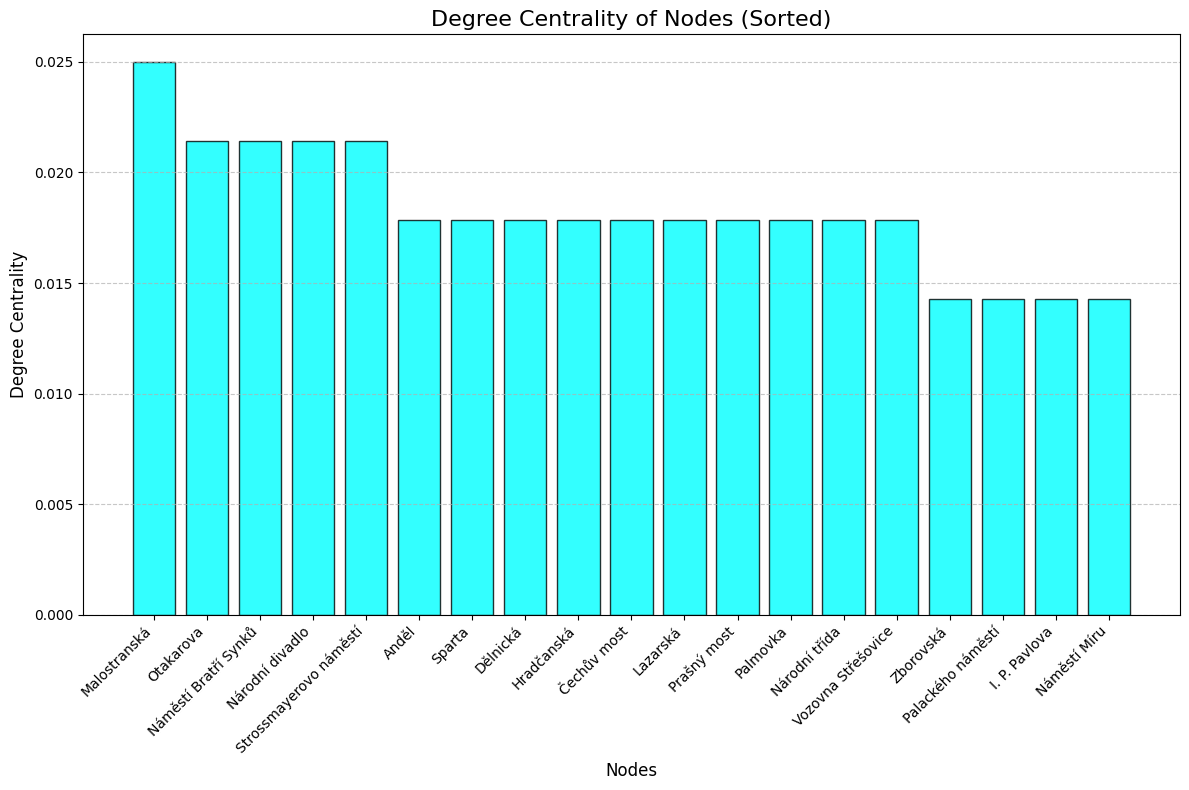

Sorted Degree Centrality (Highest to Lowest):
Node: Malostranská, Degree Centrality: 0.025
Node: Otakarova, Degree Centrality: 0.021
Node: Náměstí Bratří Synků, Degree Centrality: 0.021
Node: Národní divadlo, Degree Centrality: 0.021
Node: Strossmayerovo náměstí, Degree Centrality: 0.021
Node: Anděl, Degree Centrality: 0.018
Node: Sparta, Degree Centrality: 0.018
Node: Dělnická, Degree Centrality: 0.018
Node: Hradčanská, Degree Centrality: 0.018
Node: Čechův most, Degree Centrality: 0.018
Node: Lazarská, Degree Centrality: 0.018
Node: Prašný most, Degree Centrality: 0.018
Node: Palmovka, Degree Centrality: 0.018
Node: Národní třída, Degree Centrality: 0.018
Node: Vozovna Střešovice, Degree Centrality: 0.018
Node: Zborovská, Degree Centrality: 0.014
Node: Palackého náměstí, Degree Centrality: 0.014
Node: I. P. Pavlova, Degree Centrality: 0.014
Node: Náměstí Míru, Degree Centrality: 0.014


In [8]:
degree_centrality = nx.degree_centrality(G)
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_degree_centrality = sorted_degree_centrality[1:20]

# Unpack nodes and centrality values
nodes = [node for node, centrality in sorted_degree_centrality]
centrality_values = [centrality for node, centrality in sorted_degree_centrality]

# Plot a bar chart for nodes sorted by degree centrality
plt.figure(figsize=(12, 8))
plt.bar(nodes, centrality_values, color="cyan", alpha=0.8, edgecolor="black")
plt.title("Degree Centrality of Nodes (Sorted)", fontsize=16)
plt.xlabel("Nodes", fontsize=12)
plt.ylabel("Degree Centrality", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Print sorted centrality for reference
print("Sorted Degree Centrality (Highest to Lowest):")
for node, centrality in sorted_degree_centrality:
    print(f"Node: {node}, Degree Centrality: {centrality:.3f}")

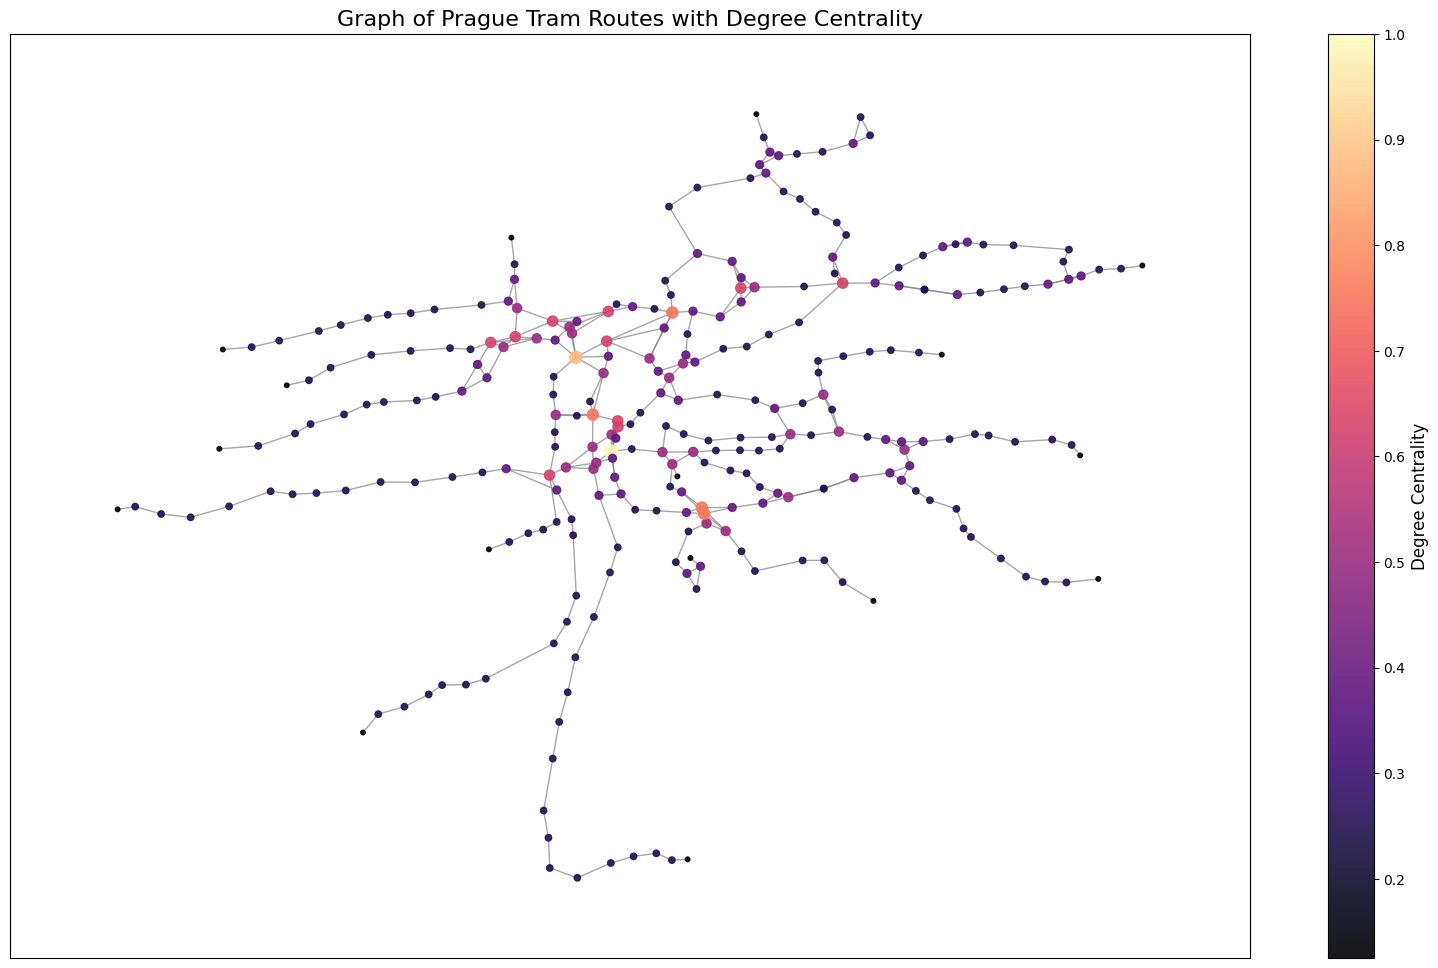

In [9]:
# Normalize centrality values for visualization
max_centrality = max(degree_centrality.values())
node_colors = [centrality / max_centrality for centrality in degree_centrality.values()]
node_sizes = [3000 * centrality for centrality in degree_centrality.values()]  # Scale node sizes

# Draw the graph with predefined positions
plt.figure(figsize=(20, 12))

# Draw nodes with size and color proportional to centrality
nodes = nx.draw_networkx_nodes(
    G, 
    pos=positions,  # Use predefined geographic positions
    node_size=node_sizes, 
    node_color=node_colors, 
    cmap=plt.cm.magma,  # Changed colormap to magma
    alpha=0.9
)

# Draw edges
nx.draw_networkx_edges(G, pos=positions, edge_color="gray", alpha=0.7)

# Add a color bar to represent degree centrality
cbar = plt.colorbar(nodes)  # Pass the `nodes` object to `plt.colorbar`
cbar.set_label("Degree Centrality", fontsize=12)

# Add a title
plt.title("Graph of Prague Tram Routes with Degree Centrality", fontsize=16)
plt.show()


# Graph Visualization: Nodes Colored by Degree Centrality

## Overview
This code visualizes a graph where nodes are:
1. **Colored** based on their degree centrality (using a colormap).
2. **Sized** proportionally to their degree centrality.

The visualization highlights important nodes in the network by adjusting their size and color intensity.

# Closeness Centrality Analysis

## Overview
This analysis computes and ranks the **closeness centrality** of nodes in a graph `G`.

Closeness centrality measures how efficiently a node can reach all other nodes in the network.

### Insights:
1. **Key Node: "Malostranská"**
   - "Malostranská" has the highest closeness centrality, meaning it can efficiently access other nodes in the network.
   - Likely acts as a central point in the graph structure.

2. **Secondary Nodes**
   - "Národní divadlo," "Staroměstská," and "Čechův most" also have significant closeness centrality values, suggesting they are important for reaching other parts of the network.

In [10]:
# Calculate closeness centrality
closeness_centrality = nx.closeness_centrality(G)

# Sort the filtered centrality values in descending order
sorted_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Display the top 5 stops by closeness centrality
print("Top 5 Stops by Closeness Centrality:")
top_stops = []
for i, (node, centrality) in enumerate(sorted_closeness[:5]):
    print(f"{i+1}. Stop: {node}, Closeness Centrality: {centrality:.4f}")
    top_stops.append({"Rank": i + 1, "Stop Name": node, "Closeness Centrality": centrality})

Top 5 Stops by Closeness Centrality:
1. Stop: Malostranská, Closeness Centrality: 0.0998
2. Stop: Národní divadlo, Closeness Centrality: 0.0989
3. Stop: Staroměstská, Closeness Centrality: 0.0986
4. Stop: Čechův most, Closeness Centrality: 0.0983
5. Stop: Právnická fakulta, Closeness Centrality: 0.0981


# Eigenvector Centrality Analysis

## Overview
This analysis computes and ranks the **eigenvector centrality** of nodes in a graph `G`.

Eigenvector centrality measures the influence of a node in a network by considering both the number of connections a node has and the importance of its neighbors.

### Insights:
1. **Key Node: "Karlovo náměstí"**
   - "Karlovo náměstí" has the highest eigenvector centrality, making it the most influential node in the network. It is not only well-connected but also connected to other important nodes.

2. **Secondary Influencers**
   - Nodes like "Národní třída, Lazarská" and "Myslíkova" also exhibit high eigenvector centrality, indicating their significance in connecting influential parts of the network.

In [11]:
# Calculate eigenvector centrality for the graph G
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06)

# Sort the eigenvector centrality values in descending order
sorted_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Display the top 5 nodes by eigenvector centrality
print("Top 5 Nodes by Eigenvector Centrality:")
top_eigenvector_stops = []
for i, (node, centrality) in enumerate(sorted_eigenvector[:5]):
    print(f"{i+1}. Node: {node}, Eigenvector Centrality: {centrality:.4f}")
    top_eigenvector_stops.append({"Rank": i + 1, "Node": node, "Eigenvector Centrality": centrality})

Top 5 Nodes by Eigenvector Centrality:
1. Node: Karlovo náměstí, Eigenvector Centrality: 0.4817
2. Node: Národní třída, Eigenvector Centrality: 0.3841
3. Node: Lazarská, Eigenvector Centrality: 0.3637
4. Node: Myslíkova, Eigenvector Centrality: 0.3281
5. Node: Novoměstská radnice, Eigenvector Centrality: 0.2851


# Question 1: What are the most overloaded stops?

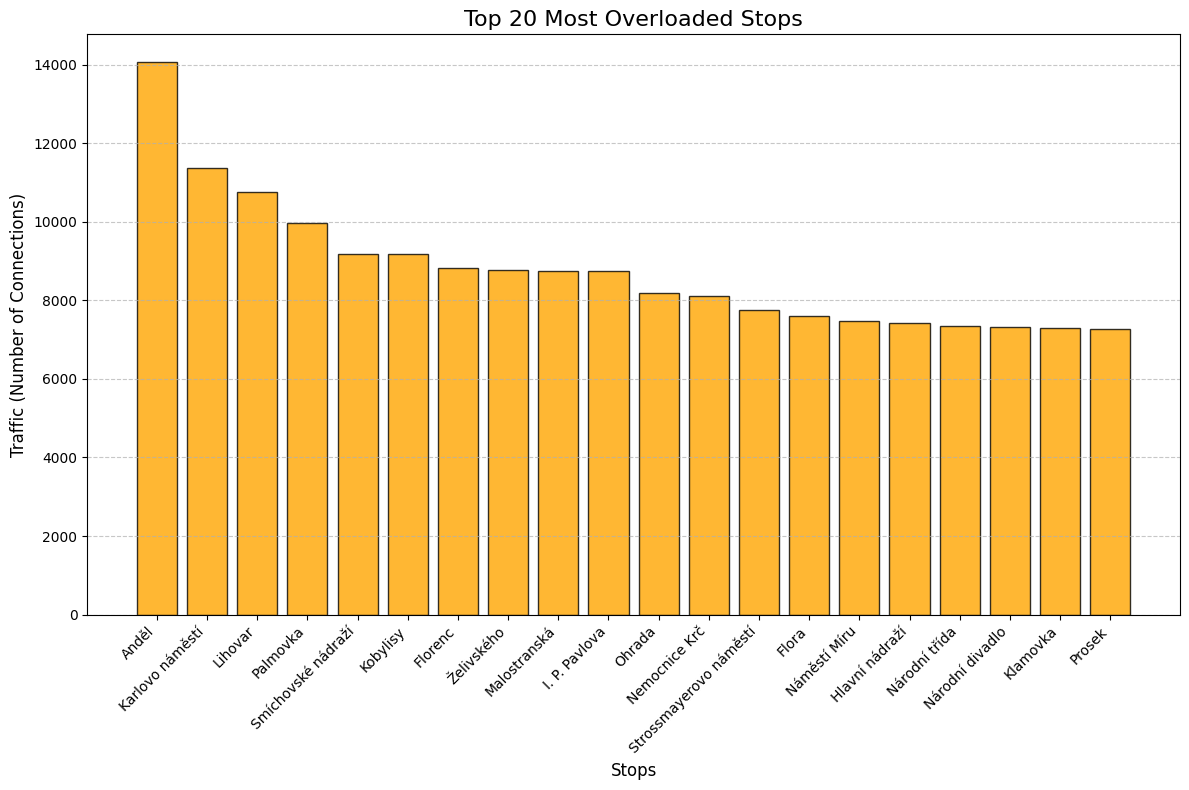

Top 20 Most Overloaded Stops:
                        Stop  Traffic
4                      Anděl  14071.0
1821         Karlovo náměstí  11368.0
2860                 Lihovar  10772.0
4185                Palmovka   9983.0
5274      Smíchovské nádraží   9188.0
2105                Kobylisy   9169.0
1178                 Florenc   8822.0
7342              Želivského   8779.0
3069            Malostranská   8754.0
1534           I. P. Pavlova   8737.0
4028                  Ohrada   8190.0
3650           Nemocnice Krč   8107.0
5424  Strossmayerovo náměstí   7762.0
1177                   Flora   7599.0
3961            Náměstí Míru   7466.0
1237          Hlavní nádraží   7420.0
3969           Národní třída   7355.0
3967         Národní divadlo   7329.0
1991                Klamovka   7294.0
4568                  Prosek   7264.0


In [12]:
traffic_from = df['stop_from_name'].value_counts()
traffic_to = df['stop_to_name'].value_counts()

# Combine counts for total traffic
total_traffic = (traffic_from + traffic_to).fillna(0)

# Convert to a DataFrame for sorting and plotting
traffic_df = total_traffic.reset_index()
traffic_df.columns = ['Stop', 'Traffic']
traffic_df.sort_values(by='Traffic', ascending=False, inplace=True)

# Filter top 20 stops
top_stops = traffic_df.head(20)

# Visualization: Bar Chart
plt.figure(figsize=(12, 8))
plt.bar(top_stops['Stop'], top_stops['Traffic'], color='orange', alpha=0.8, edgecolor='black')
plt.title("Top 20 Most Overloaded Stops", fontsize=16)
plt.xlabel("Stops", fontsize=12)
plt.ylabel("Traffic (Number of Connections)", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the top 20 stops in tabular format
print("Top 20 Most Overloaded Stops:")
print(top_stops)

## Insights:
1. **Most Overloaded Stop: "Anděl"**
   - "Anděl" has the highest traffic, significantly outpacing other stops. This indicates that "Anděl" is the busiest and likely a major hub in the network.

2. **Other Key Stops:**
   - Stops like "Karlovo náměstí," "Úlhovar," and "Palmovka" also exhibit high traffic, functioning as secondary hubs.
   - These stops are critical for managing traffic flow and ensuring network efficiency.

3. **Traffic Patterns:**
   - The decrease in bar heights shows that while some stops are extremely busy, others have slightly lower but still substantial traffic.
   - This distribution might highlight the need for better load balancing or infrastructure improvements at key points.

# Question 2:
## how does traffic activity vary throughout the day and what are the peak hours?

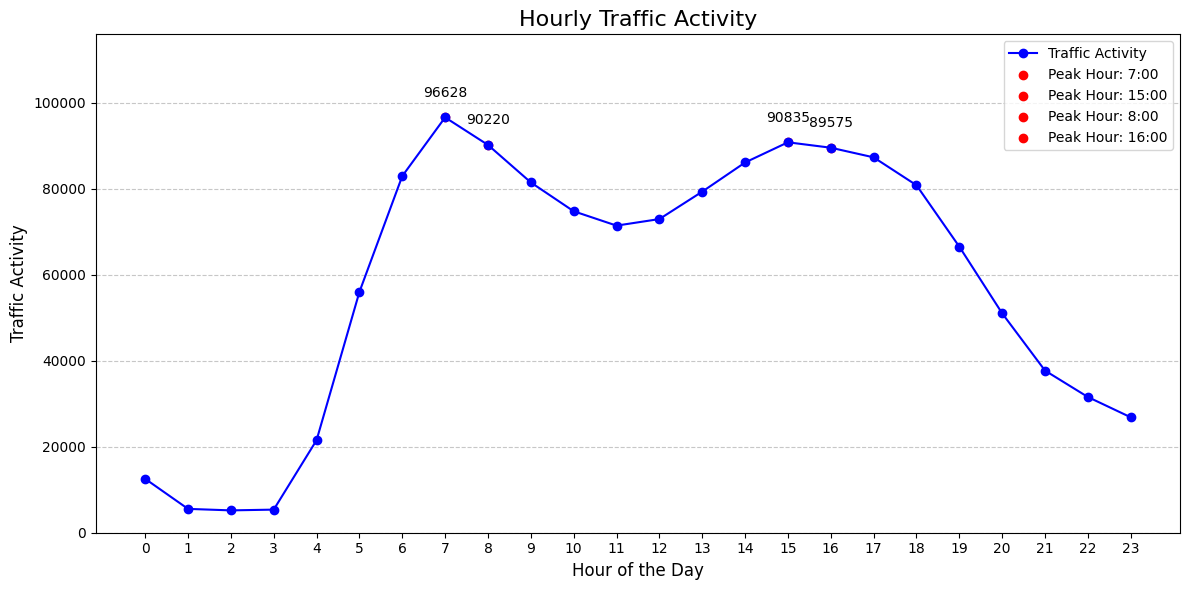

In [13]:
df['hour'] = pd.to_datetime(df['depart_from']).dt.hour

# Group by hour and calculate total activity
hourly_traffic = df.groupby('hour').size().reset_index(name='Traffic Activity')

# Find the top 4 peak hours
top_4_hours = hourly_traffic.nlargest(4, 'Traffic Activity')

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(hourly_traffic['hour'], hourly_traffic['Traffic Activity'], marker='o', linestyle='-', color='blue', label='Traffic Activity')

# Highlight the top 4 peak hours and annotate the traffic activity
y_max = hourly_traffic['Traffic Activity'].max()  # Max y-axis value
for _, row in top_4_hours.iterrows():
    plt.scatter(row['hour'], row['Traffic Activity'], color='red', label=f"Peak Hour: {int(row['hour'])}:00")
    # Adjust the text position slightly above the data point
    text_position = row['Traffic Activity'] + (y_max * 0.05)
    plt.text(row['hour'], text_position,  # Position the text above the point
             f"{int(row['Traffic Activity'])}", 
             color='black', fontsize=10, ha='center')

# Adjust y-axis limits to give more space for labels
plt.ylim(0, y_max * 1.2)

# Add legend and labels
plt.title("Hourly Traffic Activity", fontsize=16)
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Traffic Activity", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


## Overview:
This analysis explores how traffic activity fluctuates across different hours of the day.

## Insights:
### Traffic Trends:
1. **Morning Peak:**
   - Traffic activity peaks at **7:00 AM** (96628 connections), marking the highest activity of the day.
   - A secondary morning peak is observed at **8:00 AM** (90220 connections).

2. **Afternoon Peak:**
   - A significant increase in activity occurs at **3:00 PM** (15:00) and **4:00 PM** (16:00), indicating high traffic during these hours.

3. **Off-Peak Hours:**
   - Traffic activity is at its lowest during late night and early morning hours (0:00–4:00).

### General Observations:
- Traffic activity follows a **bimodal pattern** with distinct peaks during the morning and afternoon hours.
- Activity gradually declines in the evening after the second peak, reaching its minimum during late-night hours.

# Question 3:
## What proportion of traffic occurs during night versus day?

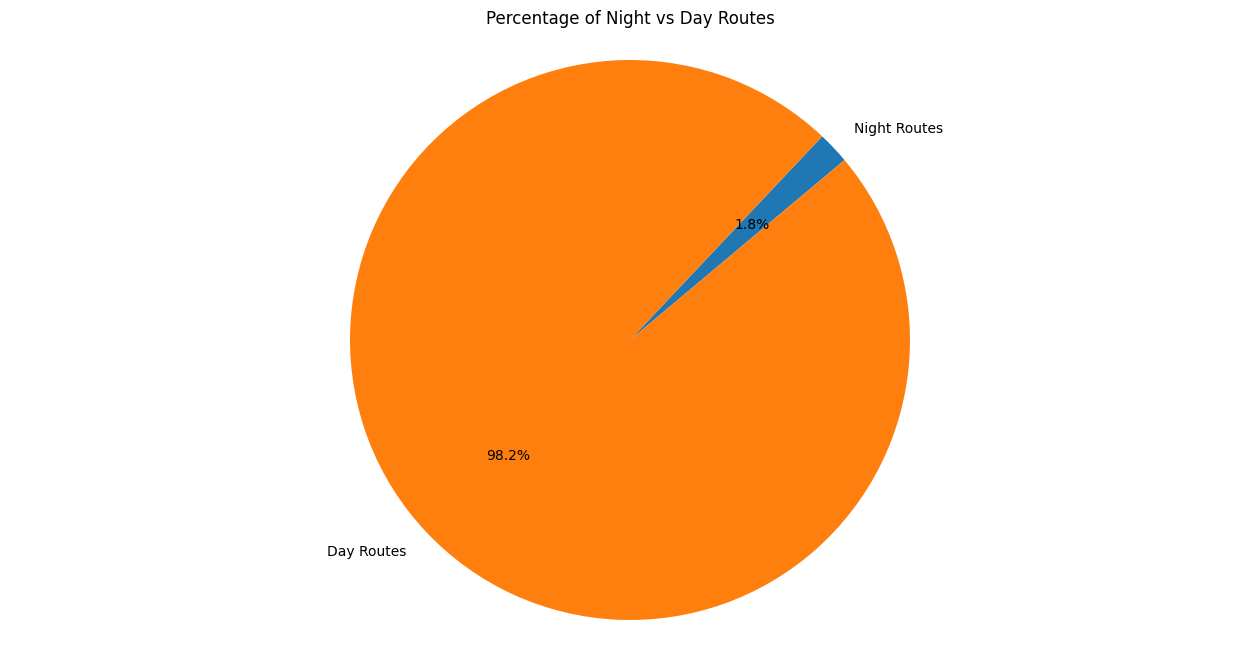

In [14]:
total_routes = len(df)
night_routes = df['is_night'].sum()
day_routes = total_routes - night_routes

night_percentage = (night_routes / total_routes) * 100
day_percentage = (day_routes / total_routes) * 100

# Data for visualization
categories = ['Night Routes', 'Day Routes']
percentages = [night_percentage, day_percentage]

# Create a pie chart
plt.figure(figsize=(16, 8))
plt.pie(percentages, labels=categories, autopct='%1.1f%%', startangle=40, colors=['#1f77b4', '#ff7f0e'])
plt.title('Percentage of Night vs Day Routes')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle
plt.show()

## Overview
This pie chart illustrates the proportion of transport routes that operate during the **day** versus those that operate at **night**.

### Key Observations:
1. **Day Routes Dominance:**
   - **98.2%** of the routes operate during the day, indicating that the vast majority of transportation activity occurs during daytime hours.
   
2. **Night Routes:**
   - Only **1.8%** of the routes are operational at night, which suggests significantly reduced transportation services during these hours.

### Insights:
- The large disparity between day and night routes reflects a clear focus on meeting daytime demand, possibly due to higher passenger volume and activity during the day.
- Night routes cater to a much smaller segment of users, likely essential workers, travelers, or individuals requiring late-night transportation.


# The end, thanks for your attention ;)